# Production Model

---
This notebook contains the final production model and insights derived from it.

In [278]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
# Set seed
np.random.seed(42)
random.seed(42)
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Load Dataset

In [280]:
data = pd.read_csv('../data/data.csv')

data.head()
data.shape

(213, 34)

### Features and Target Variable

In [282]:
# Define features (X) and target variable (y)

# columns to exclude: population-related and crime-related features
crime_related_columns = [
    'count:__crimes_against_society', 
    'count:__fraud_and_other_financial_crimes', 
    'count:__property_crime', 
    'count:__violent_crime',
    'rate:__crimes_against_society', 
    'rate:__fraud_and_other_financial_crimes', 
    'rate:__property_crime', 
    'rate:__violent_crime',
    'total_crime_count',
    'total_crime_rate',
    'log_total_crime_rate'
]

population_related_columns = [
    'total_pop',
    'white_pop',
    'black_pop',
    'hispanic_pop',
    'asian_pop',
    'native_pop',
    'islander_pop',
    'multi_race_pop',
    'state'
]

#features to keep: exclude population-related and crime-related features
X = data.drop(columns=crime_related_columns + population_related_columns)

y = data['log_total_crime_rate']

### Train-Test Split

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (170, 14)
X_test shape: (43, 14)
y_train shape: (170,)
y_test shape: (43,)


## XG Boosting

In [297]:
# Define the parameter grid
# Define parameter grid for hyperparameter tuning
# Pipeline setup
xg_pipeline = Pipeline(steps=[
    #('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, alpha=1.5))
])
param_grid = {
    'xgb__n_estimators': [100, 200,1000],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0],
    'xgb__lambda': [0, 1, 10],       # L2 regularization
    'xgb__alpha': [0, 0.5, 1]        # L1 regularization
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    xg_pipeline,
    param_grid=param_grid,
    cv=5,                             # 5-fold cross-validation
                    
    n_jobs=-1,                        # Use all available cores
   
)

# Fit GridSearchCV to the training data
# Fit with early stopping
grid_search.fit(
    X_train, y_train,
 
)


# Retrieve best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)
# Evaluate the best model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Grid Search XG Boosting Model:")
print("Best Parameters:", best_params)

print("Best Cross-Validated R²:", best_score)

print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)
results = {
    "Dataset": ["Training", "Testing"],
    "MSE": [train_mse, test_mse],
    "MAE": [train_mae, test_mae],
    "R² Score": [train_r2, test_r2]
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results)
results_df

/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Grid Search XG Boosting Model:
Best Parameters: {'xgb__alpha': 0, 'xgb__colsample_bytree': 0.7, 'xgb__lambda': 1, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 1000, 'xgb__subsample': 0.8}
Best Cross-Validated R²: 0.5259404689073562
Training MSE: 4.0858540202718706e-05
Training MAE: 0.00507594934266956
Training R²: 0.9999668002128601
Testing MSE: 0.3691406494587004
Testing MAE: 0.4012096826311166
Testing R²: 0.6518414616584778


,Dataset,MSE,MAE,R² Score
0,Training,0.000041,0.005076,0.999967
1,Testing,0.369141,0.401210,0.651841


## Feature Importances in Gradient Boosting Model

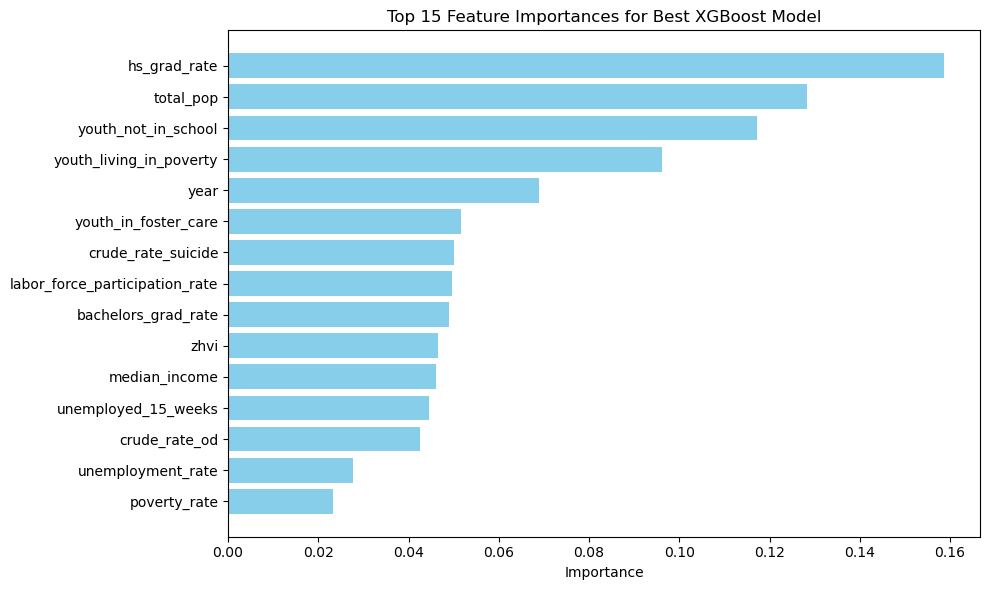

In [298]:
# Extract feature importance from the best model
feature_importance = best_model.named_steps['xgb'].feature_importances_

# Combine feature names and their corresponding importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

# Plot the feature importances in a graph
plt.figure(figsize=(10, 6))

# Select the top 15 features for visualization
top_features = feature_importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances for Best XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


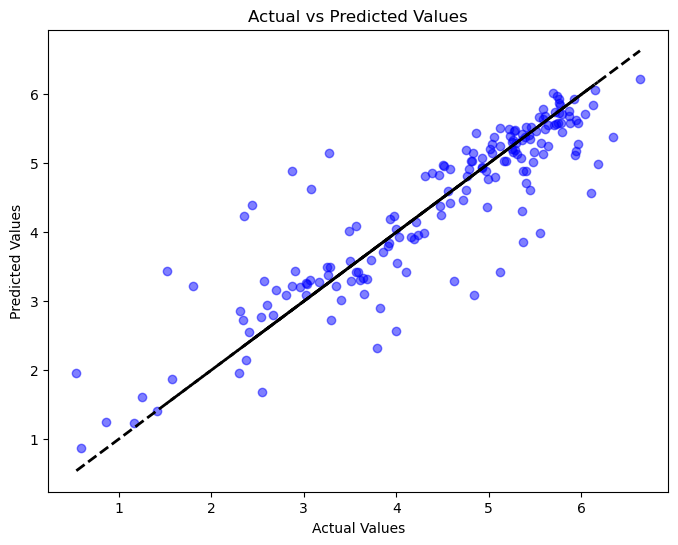

In [302]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()



## Multi-Target Prediction Performance for Gradient Boosting Model

In [304]:


#https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html
# Define features and target

# Columns to exclude
crime_related_columns = [
    'count:__crimes_against_society', 
    'count:__fraud_and_other_financial_crimes', 
    'count:__property_crime', 
    'count:__violent_crime',
    'rate:__crimes_against_society', 
    'rate:__fraud_and_other_financial_crimes', 
    'rate:__property_crime', 
    'rate:__violent_crime',
    'total_crime_count',
    'total_crime_rate',
    'log_total_crime_rate'
]

population_related_columns = [
    'white_pop',
    'black_pop',
    'hispanic_pop',
    'asian_pop',
    'native_pop',
    'islander_pop',
    'multi_race_pop',
    'state'
]

# Define features and target
X = data.drop(columns=crime_related_columns + population_related_columns)
target_features = [
    'rate:__crimes_against_society', 
    'rate:__fraud_and_other_financial_crimes', 
    'rate:__property_crime', 
    'rate:__violent_crime'
]
y = np.log1p(data[target_features])

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the multi-output model
model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
model.fit(X_train, y_train)

# Predict on testing set
y_test_pred = model.predict(X_test)

# Initialize lists to store evaluation metrics for each target
r_squared_each_output, mse_each_output, mae_each_output = [], [], []

#  store metrics for each target feature
for i, target in enumerate(target_features):
    r_squared_each_output.append(r2_score(y_test.iloc[:, i], y_test_pred[:, i]))
    mse_each_output.append(mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i]))
    mae_each_output.append(mean_absolute_error(y_test.iloc[:, i], y_test_pred[:, i]))

# Rename target features for better readability
renamed_target_features = [
    'Crimes Against Society Rate', 
    'Financial Crimes Rate', 
    'Property Crime Rate', 
    'Violent Crime Rate'
]

# Update the DataFrame with the new target feature names
metrics_df = pd.DataFrame({
    "Target Feature": renamed_target_features,
    "R2 Score": [round(score, 2) for score in r_squared_each_output],
    "MSE": [round(mse, 2) for mse in mse_each_output],
    "MAE": [round(mae, 2) for mae in mae_each_output]
})

# Display the table
metrics_df


,Target Feature,R2 Score,MSE,MAE
0,Crimes Against Society Rate,0.72,0.35,0.38
1,Financial Crimes Rate,0.70,0.31,0.40
2,Property Crime Rate,0.62,0.38,0.46
3,Violent Crime Rate,0.60,0.40,0.40
